In [1]:
!pip install einops

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, BatchNormalization, ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from einops import rearrange
from sklearn.model_selection import train_test_split

## Import Data

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


## Observe Data

In [3]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

X_train:  (60000, 28, 28)
X_test:  (10000, 28, 28)


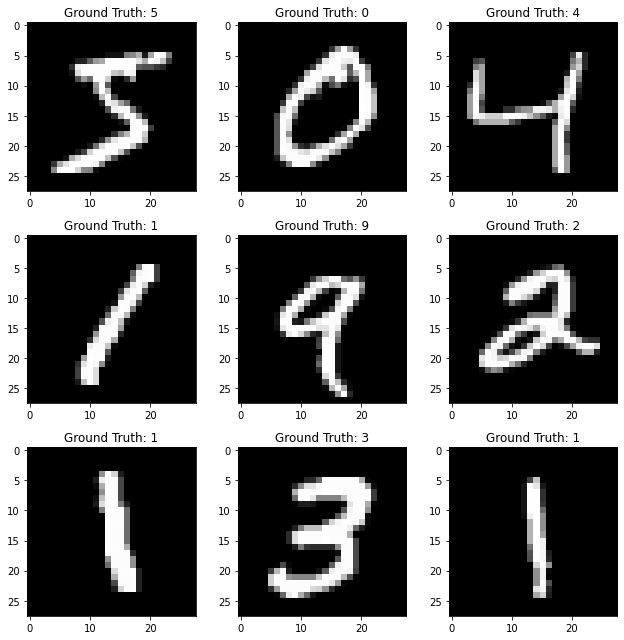

In [4]:
fig = plt.figure(figsize=(9, 9))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(X_train[i], cmap="gray", interpolation="none")
    target = y_train[i]
    plt.title("Ground Truth: {}".format(int(target)))

plt.show()

## Preprocessing

In [5]:
target_size = 10   # 0 ~ 9, 총 9개

### 주의: 흑백 데이터여도 channel 차원을 살려주어야 정상적으로 작동합니다
X_train = rearrange(X_train, "b h w -> b h w 1")
X_test = rearrange(X_test, "b h w -> b h w 1")

X_train = X_train.astype("float32") / (2 ** 8 - 1)   # 255로 scaling
X_test = X_test.astype("float32") / (2 ** 8 - 1)     # 255로 scaling

y_train = to_categorical(y_train, target_size)       # 타겟을 정수로 변환
y_test = to_categorical(y_test, target_size) 

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

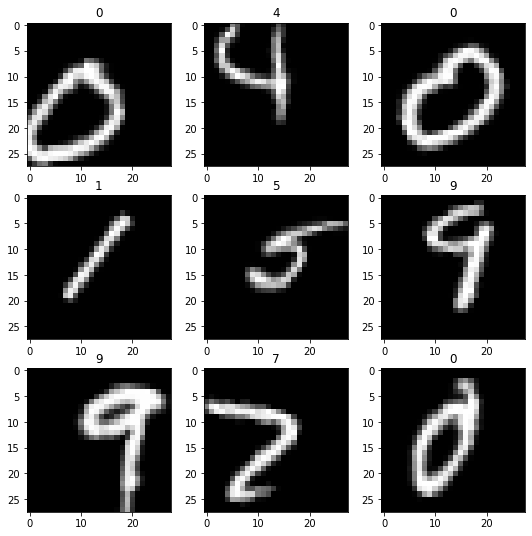

In [7]:
train_datagen = ImageDataGenerator(rotation_range=20,         # 무작위 회전 각도
                                   width_shift_range=0.2,     # 가로 shift 비율 (전체 너비 대비 비율)
                                   height_shift_range=0.2,    # 세로 shift 비율
                                   brightness_range=None,     # 밝기 변환 범위 ex) (0.2, 0.8)
                                   zoom_range=0.1,            # 확대 비율 (소수 1개 혹은 범위 지정 가능)
                                   horizontal_flip=False,     # 무작위 수평 전환
                                   vertical_flip=False,       # 무작위 수직 전환 (50% 확률)
                                   shear_range=0.2,
                                   rescale=None)              # 크기 재조절 인수 (보통 1./255를 많이 사용하지만 같은 비율로 valid data도 처리해줘야함)

train_flow = train_datagen.flow(X_train, y_train, batch_size=256, shuffle=True)
# val_flow = val_datagen.flow(X_val, y_val, batch_size=256, shuffle=False)

fig = plt.figure(figsize=(9, 9))
fig.tight_layout()

# ImageDataGenerator 결과 프린트
for X_batch, y_batch in train_datagen.flow(X_train, y_train, batch_size=9, shuffle=True):
  for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.imshow(X_batch[i].reshape(28, 28), cmap="gray", interpolation="none")
    plt.title(np.argmax(y_batch[i]))
  plt.show()
  break


In [8]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)
(48000, 10)
(12000, 10)
(10000, 10)


In [9]:
inputs = Input(shape=(28, 28, 1)) 

X = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(inputs)
X = BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform")(X)
X = ReLU()(X)
X = Conv2D(64, (3,3), padding='same')(X)
X = BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform")(X)
X = ReLU()(X)
    
X = MaxPooling2D(2, 2)(X)
#    tf.keras.layers.Dropout(0.8),
    
X = Conv2D(128, (3,3), padding='same')(X)
X = BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform")(X)
X = ReLU()(X)
X = Conv2D(128, (3,3), padding='same')(X)
X = BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform")(X)
X = ReLU()(X)
    
X = MaxPooling2D(2,2)(X)
#    tf.keras.layers.Dropout(0.8),

X = Conv2D(256, (3,3), padding='same')(X)
X = BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform")(X)
X = ReLU()(X)
X = Conv2D(256, (3,3), padding='same')(X)
X = BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform")(X)
X = ReLU()(X)
    
X = MaxPooling2D(2,2)(X)
#    tf.keras.layers.Dropout(0.8),
    
X = Flatten()(X)
X = Dense(1024, activation='relu')(X)
 #   tf.keras.layers.LeakyReLU(alpha=0.1),
X = Dense(1024, activation='relu')(X)
 #   tf.keras.layers.LeakyReLU(alpha=0.1),

X = Dropout(0.6)(X)
outputs = Dense(10, activation='softmax')(X)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 28, 28, 64)        0     

In [12]:

optim = Adam(learning_rate=0.005)

acc_lst = []
source = {"Accuracy" : acc_lst}

for i in range(5):
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

  es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min')
  mc = ModelCheckpoint("best.ckpt", monitor='val_loss', verbose=1, save_best_only=True, save_weight_only=True, mode='min', restore_best_weights=True)
  rl = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_delta=0.001, min_lr=0.00001)

  history = model.fit(train_flow, batch_size=256, epochs=50, validation_data=(X_val, y_val), verbose=1, callbacks=[es, mc, rl])
  model.load_weights("best.ckpt")
  loss, acc = model.evaluate(X_test, y_test)
  print("Untrained model, accuracy: {:5.2f}%".format(100*acc))
  acc_lst.append(acc)
  del model
  

Data = pd.DataFrame(source)
print("Average test accuracy : {:5.2f}%".format(100*(sum(acc_lst)/len(acc_lst))))
Data

Epoch 1/50
188/188 [==============================] - 29s 146ms/step - loss: 0.0224 - accuracy: 0.9940 - val_loss: 0.0349 - val_accuracy: 0.9920

Epoch 00001: val_loss improved from inf to 0.03495, saving model to best.ckpt
INFO:tensorflow:Assets written to: best.ckpt/assets
Epoch 2/50
188/188 [==============================] - 27s 144ms/step - loss: 0.0192 - accuracy: 0.9945 - val_loss: 0.0330 - val_accuracy: 0.9927

Epoch 00002: val_loss improved from 0.03495 to 0.03302, saving model to best.ckpt
INFO:tensorflow:Assets written to: best.ckpt/assets
Epoch 3/50
188/188 [==============================] - 27s 144ms/step - loss: 0.0166 - accuracy: 0.9953 - val_loss: 0.0252 - val_accuracy: 0.9944

Epoch 00003: val_loss improved from 0.03302 to 0.02525, saving model to best.ckpt
INFO:tensorflow:Assets written to: best.ckpt/assets
Epoch 4/50
188/188 [==============================] - 27s 144ms/step - loss: 0.0168 - accuracy: 0.9952 - val_loss: 0.0271 - val_accuracy: 0.9940

Epoch 00004: val_l

,Accuracy
0,0.9966
1,0.9968
2,0.9960
3,0.9964
4,0.9972


위에 있는 모델은

https://tobigs.gitbook.io/tobigs/deep-learning/undefined/advanced-neural-net-2

이 링크의 SOPCNN 모델을

https://paperswithcode.com/paper/stochastic-optimization-of-plain

SOPCNN 논문에 맞게 수정한 모델입니다!

최대 정확도 99.54%

## Sources
https://towardsdatascience.com/the-quest-of-higher-accuracy-for-cnn-models-42df5d731faf

In [ ]:
model.load_weights("best.ckpt")
loss, acc = model.evaluate(X_test, y_test)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))